# 1. Import libraries and data

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

In [2]:
#read data
data = pd.read_csv('./AB_NYC_2019.csv')

# 2. Data Exploratory Analysis

## 2.1 Distribution

In [3]:
# inspect dataset size and the features
print('Shape:',data.shape)
print('Columns:',data.columns.tolist())
data.head()

Shape: (48895, 16)
Columns: ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
#inspect data types of features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [5]:
#convert datetime type
data['last_review'] = pd.to_datetime(data['last_review'], infer_datetime_format=True)

**This dataset contains 48,895 samples with 16 features，including host and room information, location, room type, reviews information.**

## 2.2 Deal with missing values

In [15]:
#1.number of missing values in each column
total = data.isnull().sum().sort_values(ascending=False) 
# 2.proportion of missing values
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total,percent], axis=1, keys = ['Total','Percentage']).sort_values(by='Total', ascending = False)
missing_data

,Total,Percentage
reviews_per_month,10052,0.205583
last_review,10052,0.205583
host_name,21,0.000429
name,16,0.000327
availability_365,0,0.000000
calculated_host_listings_count,0,0.000000
number_of_reviews,0,0.000000
minimum_nights,0,0.000000
price,0,0.000000
room_type,0,0.000000


summary:

columns have missing values: reviews per month, last review, host name, listing name.

1.name and host_name can be dropped since they are not relavent for modeling
2.reviews per month, last review has 20% of missing values，dropping will result in losing information. So we will fill in the missing values. 
  Considering that if some rooms don't have reviews, these two columns would be 0. Let's first try to see if the missing valeus are related to zero reviews.

In [18]:
data.drop(['host_name','name'], axis=1, inplace=True)

In [22]:
data[data.number_of_reviews==0].shape #equal result to reviews_per_month

(10052, 14)

Then we can use 0 to fill in reviews_per_month and use the ealiest record of datetime to fill in last_review.

In [24]:
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)
earliest = min(data['last_review'])
data['last_review'] = data['last_review'].fillna(earliest)

To make it easier for modeling, we convert the last_review to numeric, based on the difference to the earliest record

In [25]:
data['last_review'] = data['last_review'].apply(lambda x:x.toordinal() - earliest.toordinal())

# 3. Further exploratory data analysis

In [27]:
data.columns.tolist()

['id',
 'host_id',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

## 3.1 host_id

In [28]:
total = len(data['host_id'].unique())
percent = len(data['host_id'].unique())/data.shape[0]
print(f'Unique num of host_id:{total}')
print(f'precent:{percent}')

Unique num of host_id:37457
precent:0.7660701503221188


host_id has many different levels(76%),this discrete data is not important in model, we will drop host_id and id for the same reason

In [29]:
data = data.drop(columns=['host_id', 'id'], axis=1)

## 3.2 neighrborhood_group

In [30]:
data['neighbourhood_group'].value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

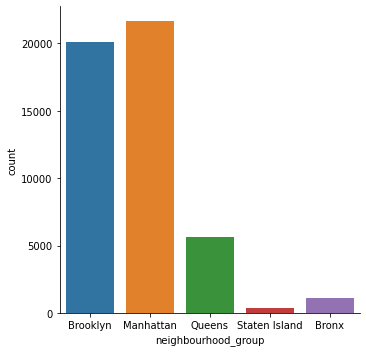

In [33]:
sns.catplot(x='neighbourhood_group', kind='count', data=data)
fig = plt.gca()

Manhattan and Brooklyn are the top 2 populous boroughs in New York.

## 3.3 longitude and latitude

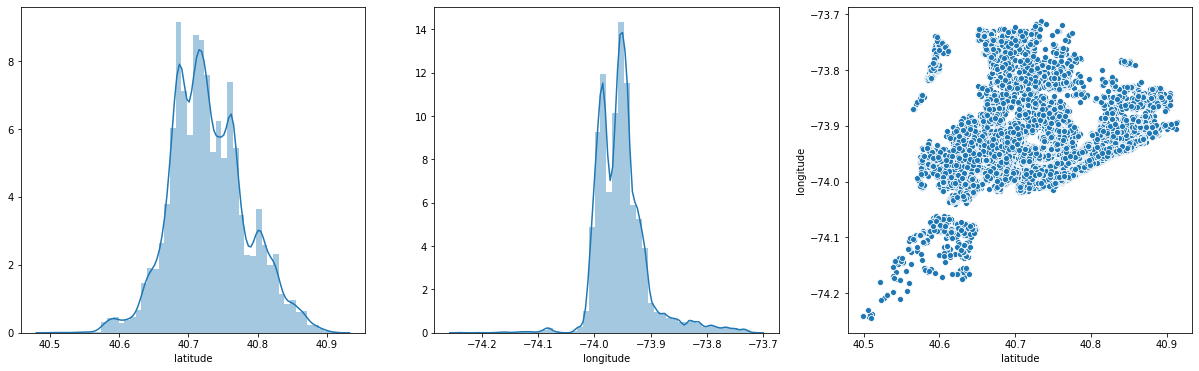

In [35]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['latitude'], ax=axes[0])
sns.distplot(data['longitude'], ax=axes[1])
sns.scatterplot(x= data['latitude'], y=data['longitude'])

## 3.4 room type

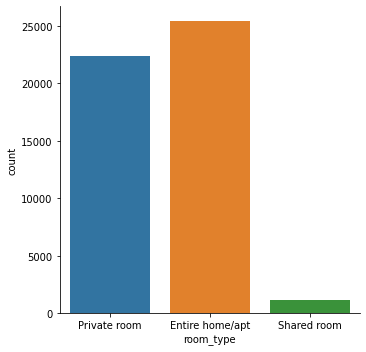

In [37]:
sns.catplot(x='room_type',  kind='count', data=data)
fig = plt.gca()

## 3.4 minimum nights

Text(0, 0.5, 'Sample size statistics')

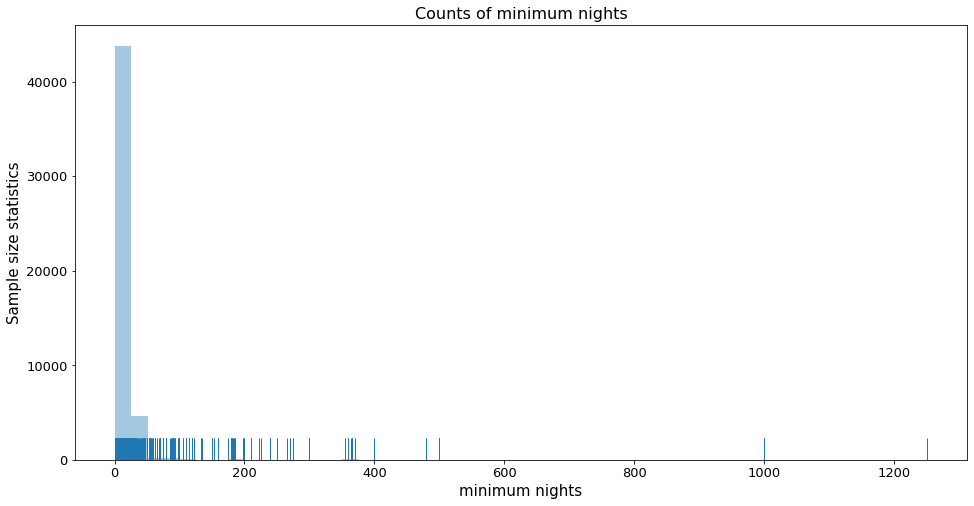

In [38]:
fig,ax=plt.subplots(figsize=(16,8))
sns.distplot(data['minimum_nights'],kde=False,rug=True)
ax.set_title('Counts of minimum nights',fontsize=16)
ax.tick_params(labelsize=13)
ax.set_xlabel('minimum nights', fontsize=15)
ax.set_ylabel('Sample size statistics',fontsize=15)

this data is heavily right skewd, majority listings have small value of minimum nights

In [39]:
data['minimum_nights'].describe(percentiles=[.25, .5, .75, .95, .99])

count    48895.000000
mean         7.029962
std         20.510550
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
95%         30.000000
99%         45.000000
max       1250.000000
Name: minimum_nights, dtype: float64

99% values of minimum nights are below 45. To handle heavily skewed data, we can use numpy.log1p(). np.log1p(x) = log(1+x).

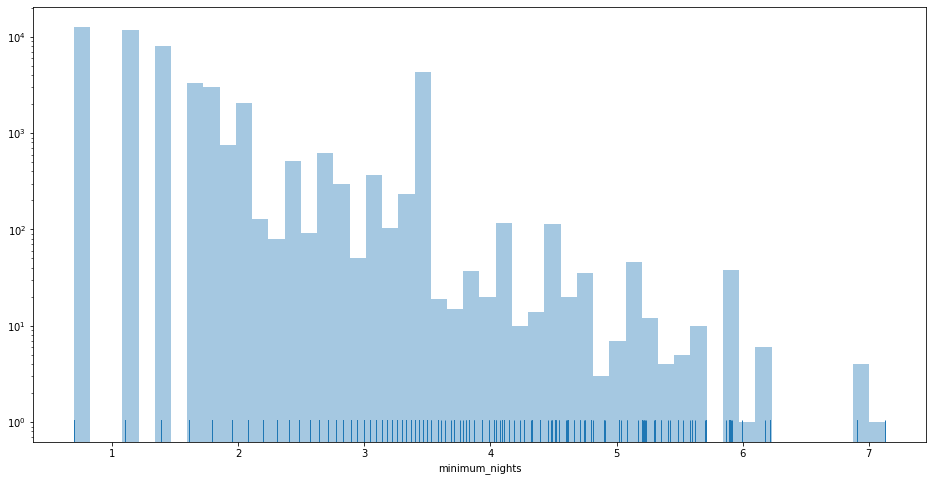

In [40]:
fig,ax=plt.subplots(figsize=(16,8))
ax.set_yscale('log')
sns.distplot(np.log1p(data['minimum_nights']),rug=True,kde=False)

then replace the log transformed data 

In [42]:
data['minimum_nights'] = np.log1p(data['minimum_nights'])

## 3.6 reviews per month

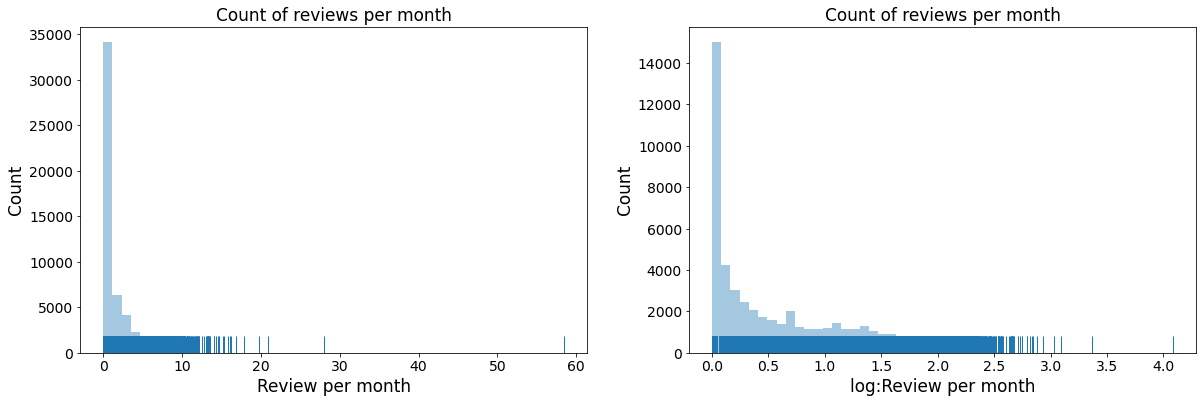

In [43]:
fig,ax=plt.subplots(1,2,figsize=(20,6))
sns.distplot(data['reviews_per_month'],rug=True,kde=False,ax=ax[0])
ax[0].set_title('Count of reviews per month',fontsize=17)
ax[0].set_ylabel('Count',fontsize=17)
ax[0].set_xlabel('Review per month',fontsize=17)
ax[0].tick_params(labelsize=14)

sns.distplot(np.log1p(data['reviews_per_month']),rug=True,kde=False,ax=ax[1])
ax[1].set_title('log :Count of review per month')
ax[1].set_title('Count of reviews per month',fontsize=17)
ax[1].set_ylabel('Count',fontsize=17)
ax[1].set_xlabel('log:Review per month',fontsize=17)
ax[1].tick_params(labelsize=14)

even after log1p transformation, the count of reviews still has heavy skewness

In [44]:
data['reviews_per_month'].describe(percentiles=[.25, .5, .75, .95, .99])

count    48895.000000
mean         1.090910
std          1.597283
min          0.000000
25%          0.040000
50%          0.370000
75%          1.580000
95%          4.310000
99%          6.800000
max         58.500000
Name: reviews_per_month, dtype: float64

we can see that 99% of data has reviews_per_month within 7. Only a small portion of records has big numbers of reviews per month.

we can have a hypothesis that reviews_per_month, minimum_nights and availability_365 could have some correlations since if minimum nights are long, the number of orders will be fewer and thus result in fewer reviews. We will have further analysis later.


## 3.7 availability 365

(0.0, 365.0)

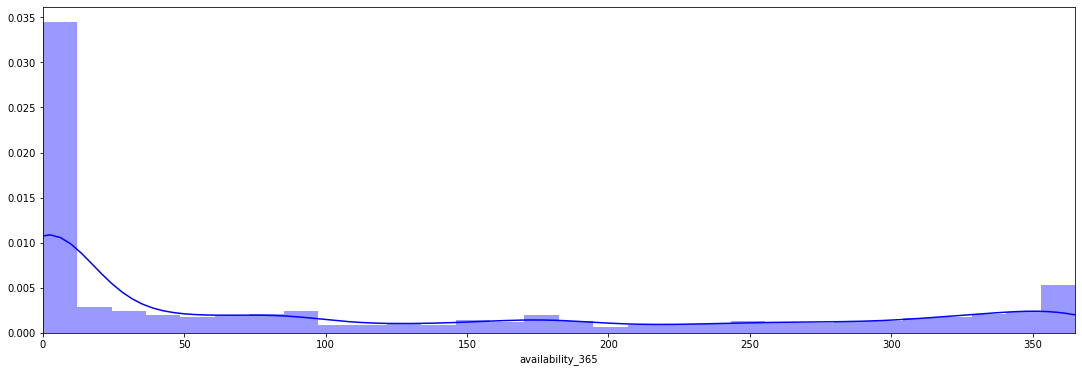

In [45]:
fig, axes = plt.subplots(1,1,figsize=(18.5, 6))
sns.distplot(data['availability_365'], rug=False, kde=True, color="blue", ax=axes)
axes.set_xlabel('availability_365')
axes.set_xlim(0, 365)

## 3.8 Calculated_host_listings_count

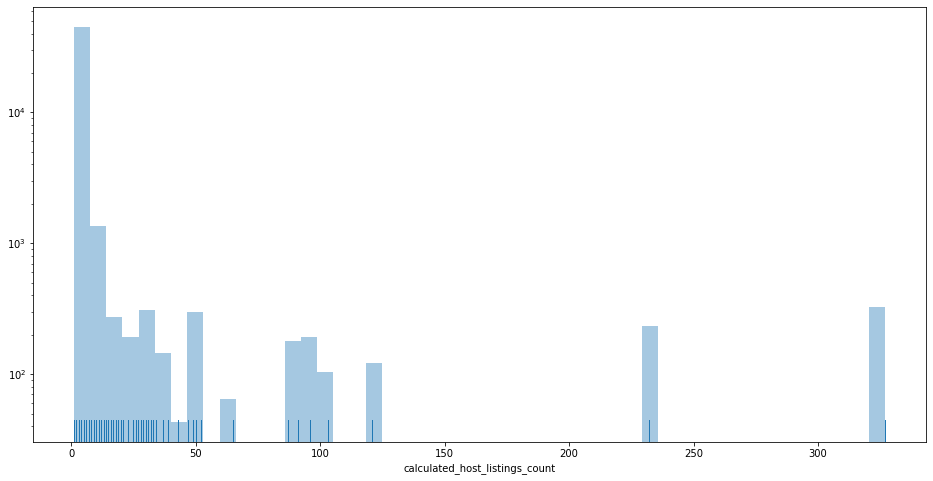

In [47]:
fig,ax=plt.subplots(1,1,figsize=(16,8))
sns.distplot(data['calculated_host_listings_count'],rug=True,kde=False)
ax.set_yscale('log')

## 3.9 Price

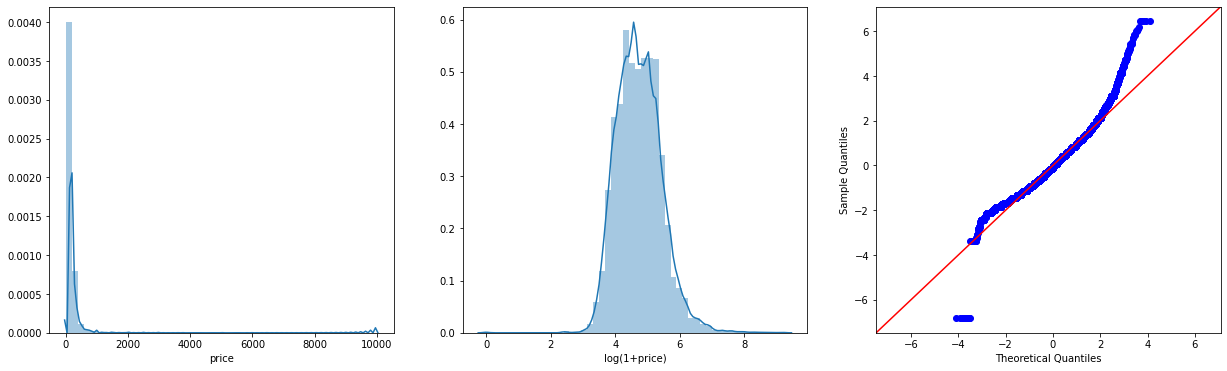

In [55]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['price'], ax=axes[0])
sns.distplot(np.log1p(data['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(data['price']), fit=True, line='45' , ax=axes[2]);

we use np.log1p() to convert price to normal distribution

In [56]:
data['price'] = np.log1p(data['price'])

# 4. relationships among features

## 4.1 pearson correlation coefficients and heatmap visualization

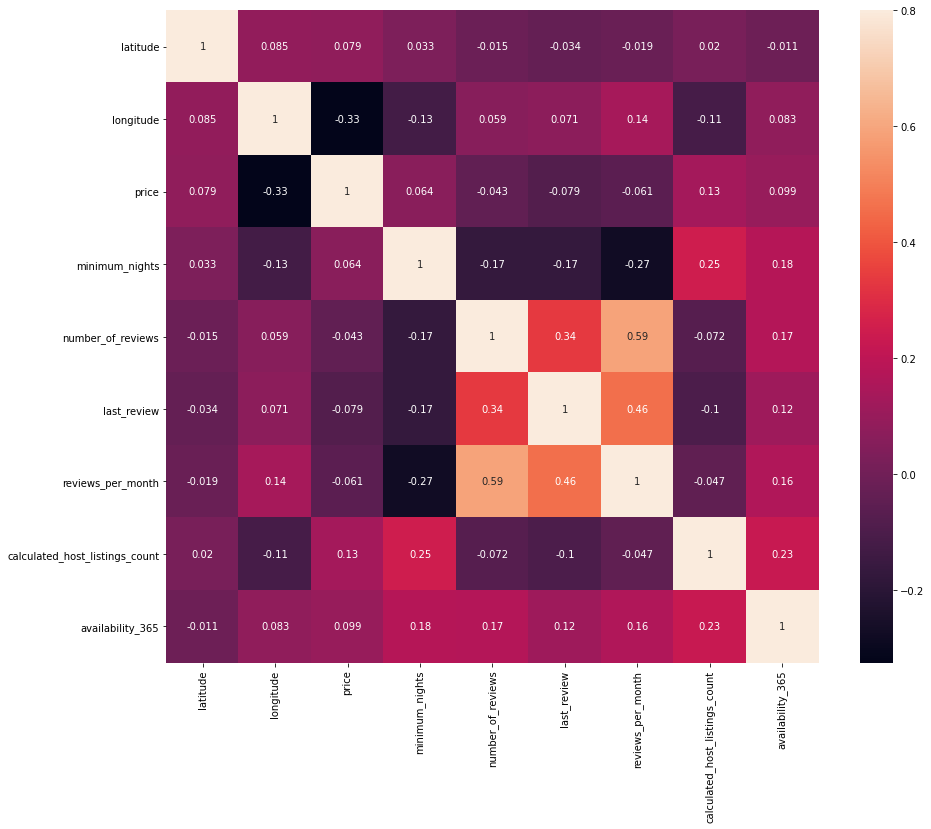

In [58]:
corrmatrix = data.corr()
f, ax = plt.subplots(figsize=(15,12))
sns.heatmap(corrmatrix, vmax=0.8, square=True,annot=True)

Summary：
1. From the heatmap we can find that number_of_reviews and reviews_per_month has the highest correlation coeficient: 0.59；last_review and reviews_per_month has the second highest, number of reviews and last review ranks the third, these three variables are correlated 
2. There are negative correlation coefficients as well: reviews_per_month and the minimum_nights, which is same as our analysis in 3.6.

3. price and longitude has relative higher correlation: -0.33

## 4.2 Scatter Plot

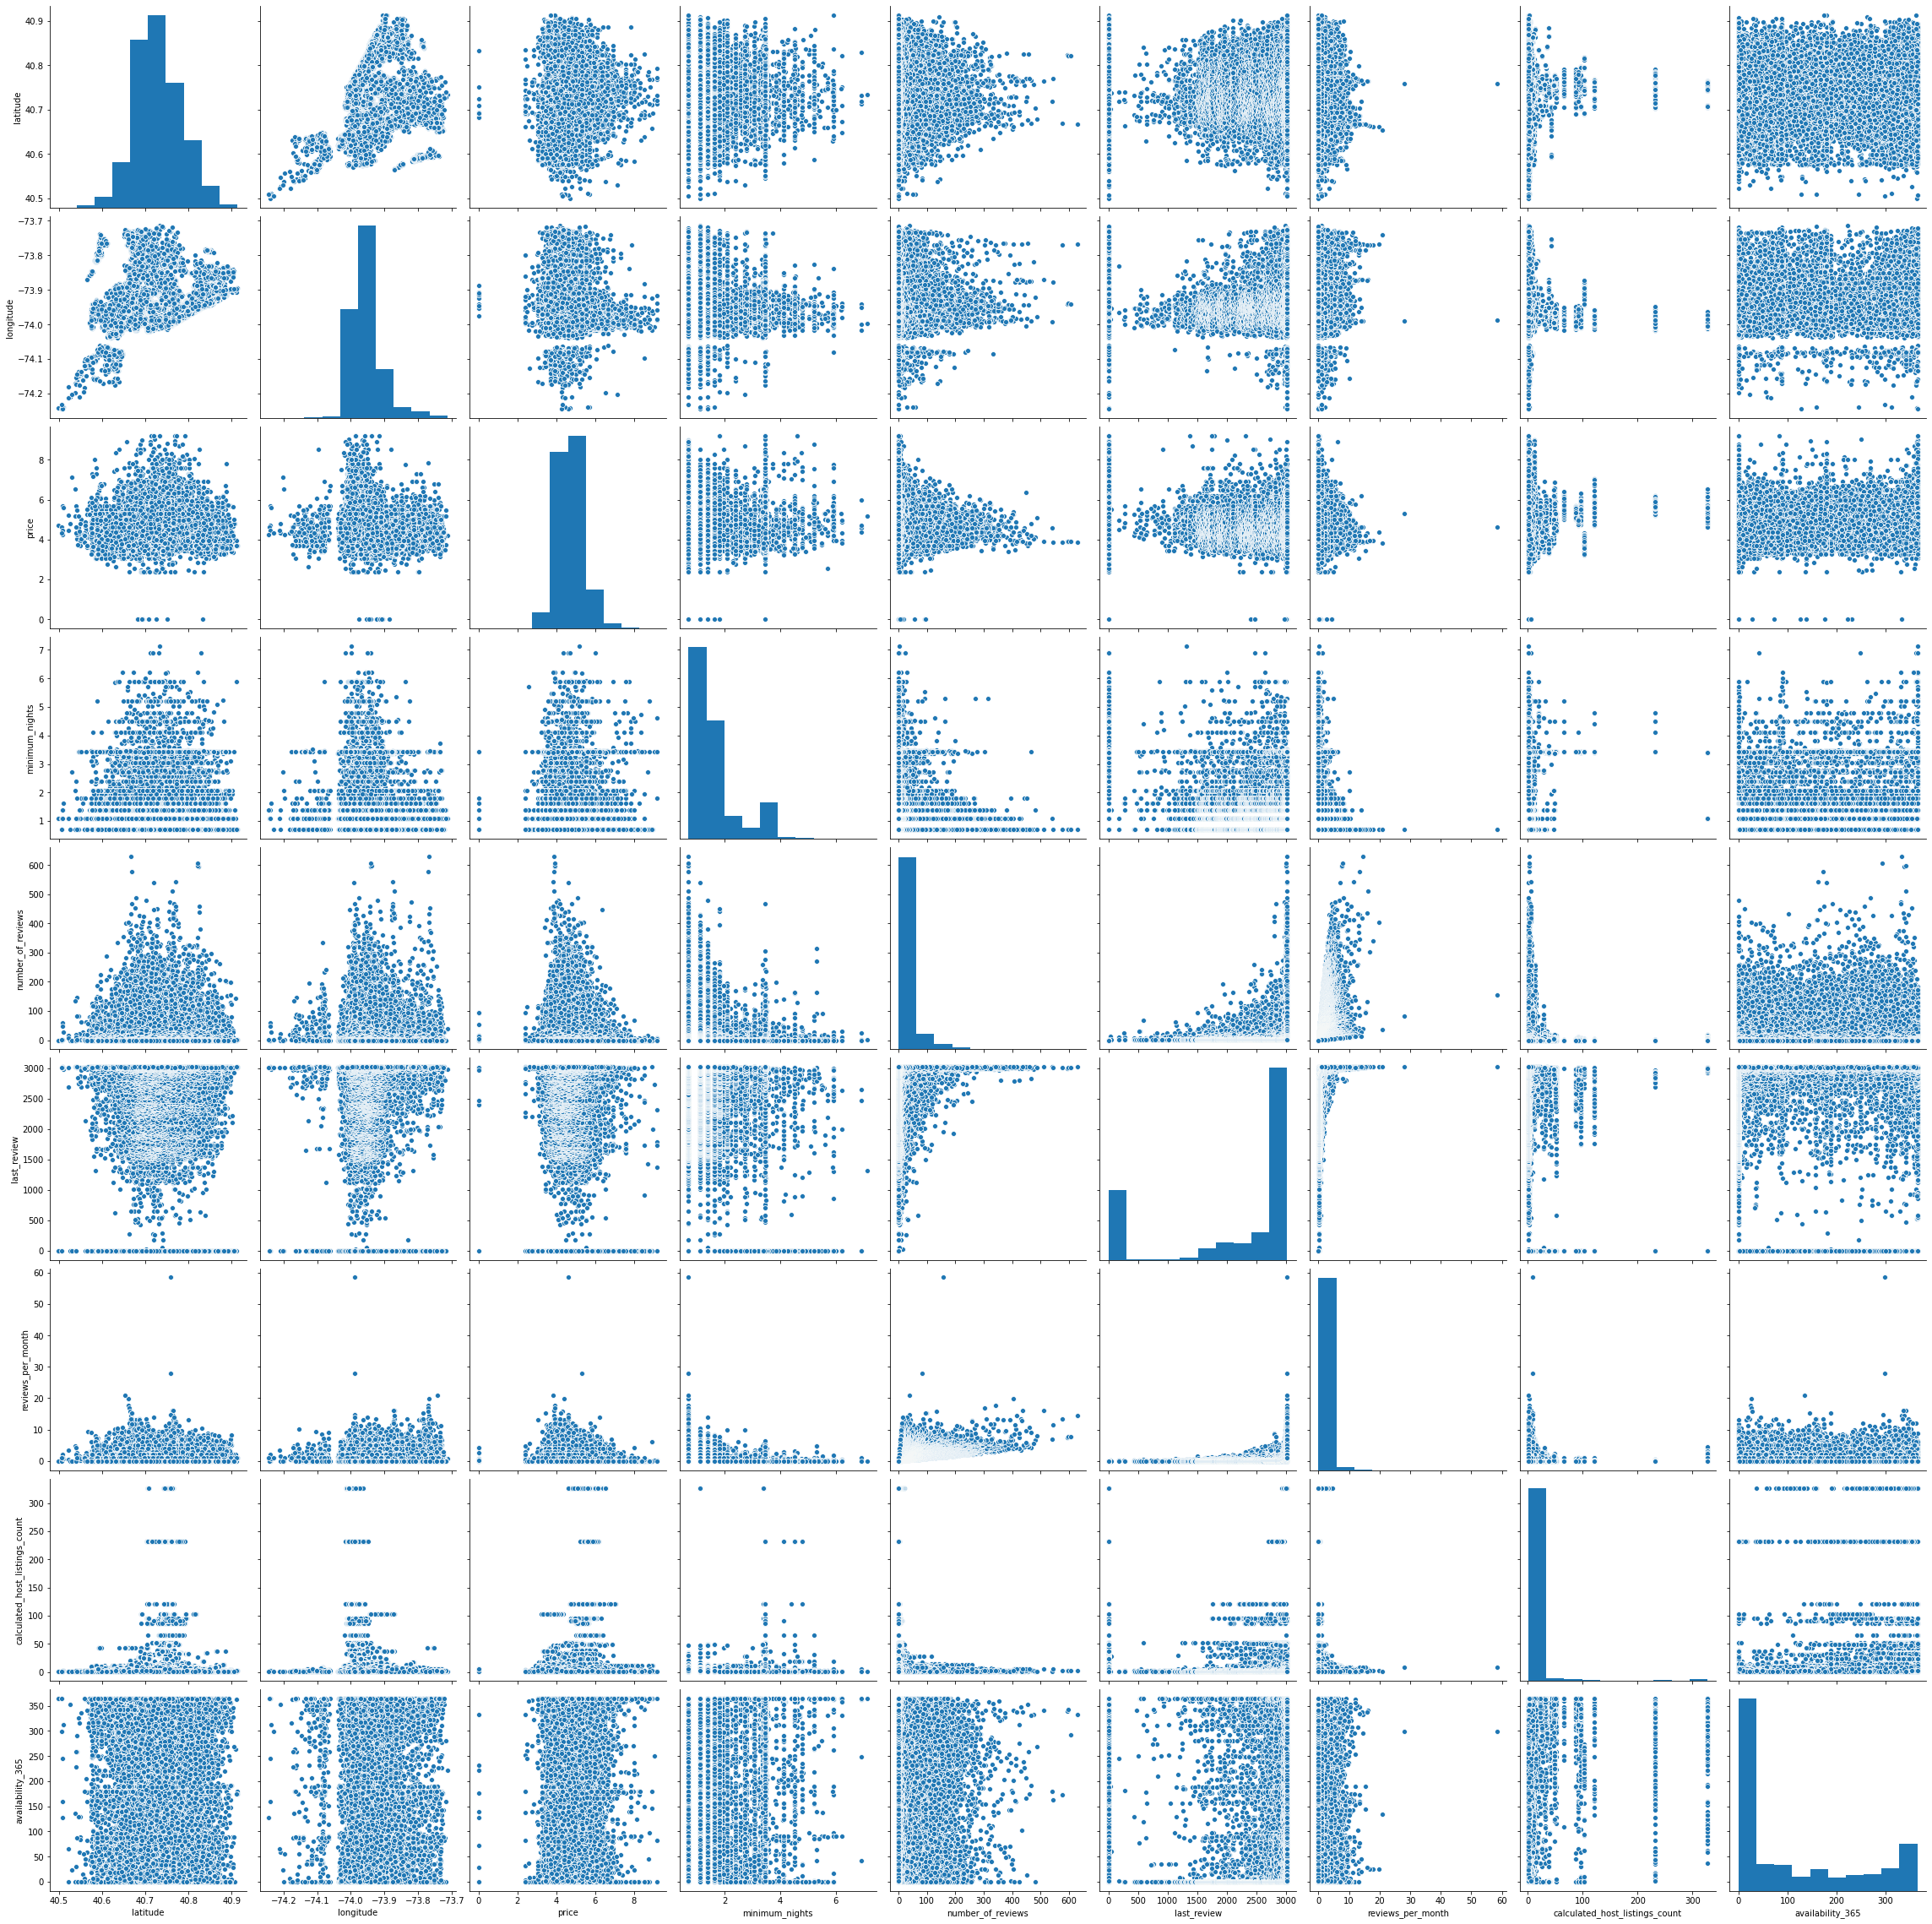

In [59]:
sns.pairplot(data.select_dtypes(exclude=['object']),height=3.5) #only use numeric vaiables

check number_of_reviews, price, longitude and latitude

Text(0, 0.5, 'latitude')

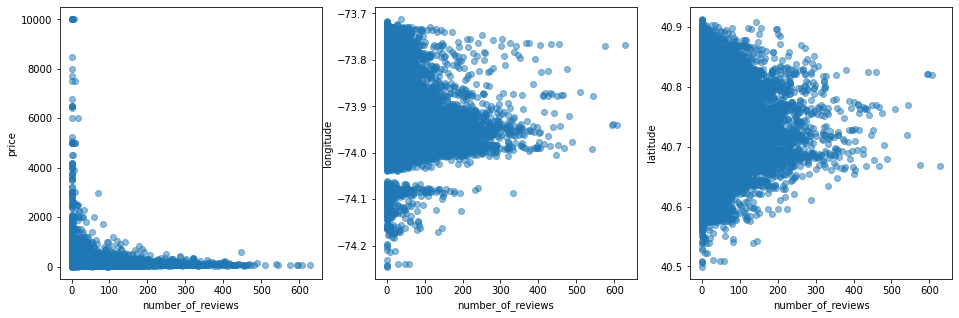

In [60]:
fig,ax=plt.subplots(1,3,figsize=(16,5))
ax[0].scatter(x=data['number_of_reviews'],y=np.exp(data['price'])-1,alpha=.5)
ax[0].set_xlabel(xlabel='number_of_reviews')
ax[0].set_ylabel(ylabel='price')

ax[1].scatter(x=data['number_of_reviews'],y=data['longitude'],alpha=.5)
ax[1].set_xlabel(xlabel='number_of_reviews')
ax[1].set_ylabel(ylabel='longitude')

ax[2].scatter(x=data['number_of_reviews'],y=data['latitude'],alpha=.5)
ax[2].set_xlabel(xlabel='number_of_reviews')
ax[2].set_ylabel(ylabel='latitude')

Summary：
1. number_of_reviews can reflect popularity of the listing. We can see that listings less than 500 have more reviews. Meanwhile, the more closer the longitude to -74 ~ -73.9, and the latitude the closer to 40.7, the listings have more reviews.

2. The fewer minimum_nights, the more reviews the listing has.

# 5. Modeling Preparation

## 5.1 object to dummy variables

In [61]:
object_features = data.select_dtypes(include=['object'])
object_features.columns

Index(['neighbourhood_group', 'neighbourhood', 'room_type'], dtype='object')

In [62]:
object_features_oh=pd.get_dummies(object_features)
object_features_oh.head()

,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Allerton,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,...,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## 5.2 Prepare dataset

In [64]:
#extract numeric features
num_features = data.select_dtypes(exclude=['object'])
#extract target
y = num_features.loc[:,'price']
num_features.drop(columns=['price'],axis=1,inplace=True)
#make a new dataset
new_data = pd.concat([num_features,object_features_oh,y],axis=1)
#get features
new_data.columns.tolist()

['latitude',
 'longitude',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'neighbourhood_group_Bronx',
 'neighbourhood_group_Brooklyn',
 'neighbourhood_group_Manhattan',
 'neighbourhood_group_Queens',
 'neighbourhood_group_Staten Island',
 'neighbourhood_Allerton',
 'neighbourhood_Arden Heights',
 'neighbourhood_Arrochar',
 'neighbourhood_Arverne',
 'neighbourhood_Astoria',
 'neighbourhood_Bath Beach',
 'neighbourhood_Battery Park City',
 'neighbourhood_Bay Ridge',
 'neighbourhood_Bay Terrace',
 'neighbourhood_Bay Terrace, Staten Island',
 'neighbourhood_Baychester',
 'neighbourhood_Bayside',
 'neighbourhood_Bayswater',
 'neighbourhood_Bedford-Stuyvesant',
 'neighbourhood_Belle Harbor',
 'neighbourhood_Bellerose',
 'neighbourhood_Belmont',
 'neighbourhood_Bensonhurst',
 'neighbourhood_Bergen Beach',
 'neighbourhood_Boerum Hill',
 'neighbourhood_Borough Park',
 'neighbourhood_Breezy Point',
 'neighb

In [65]:
new_data.shape

(48895, 238)

export dataset to train model

In [66]:
#new_data.to_csv('Processed_AB_NYC2019.csv')

# 6. Predictive Modeling

## 6.1 Train and test splits

In [69]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(new_data.drop('price',axis = 1),y,test_size=0.2,random_state=42)
print(f'The shape of Xtrain:{Xtrain.shape}')
print(f'The shape of Xtest:{Xtest.shape}')
print(f'The shape of ytrain:{ytrain.shape}')
print(f'The shape of ytest:{ytest.shape}')

The shape of Xtrain:(39116, 237)
The shape of Xtest:(9779, 237)
The shape of ytrain:(39116,)
The shape of ytest:(9779,)


In [73]:
Xtrain.columns.tolist()

['latitude',
 'longitude',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'neighbourhood_group_Bronx',
 'neighbourhood_group_Brooklyn',
 'neighbourhood_group_Manhattan',
 'neighbourhood_group_Queens',
 'neighbourhood_group_Staten Island',
 'neighbourhood_Allerton',
 'neighbourhood_Arden Heights',
 'neighbourhood_Arrochar',
 'neighbourhood_Arverne',
 'neighbourhood_Astoria',
 'neighbourhood_Bath Beach',
 'neighbourhood_Battery Park City',
 'neighbourhood_Bay Ridge',
 'neighbourhood_Bay Terrace',
 'neighbourhood_Bay Terrace, Staten Island',
 'neighbourhood_Baychester',
 'neighbourhood_Bayside',
 'neighbourhood_Bayswater',
 'neighbourhood_Bedford-Stuyvesant',
 'neighbourhood_Belle Harbor',
 'neighbourhood_Bellerose',
 'neighbourhood_Belmont',
 'neighbourhood_Bensonhurst',
 'neighbourhood_Bergen Beach',
 'neighbourhood_Boerum Hill',
 'neighbourhood_Borough Park',
 'neighbourhood_Breezy Point',
 'neighb

In [75]:
new_data.head()

,latitude,longitude,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,...,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,price
0,40.64749,-73.97237,0.693147,9,2762,0.21,6,365,0,1,...,0,0,0,0,0,0,0,1,0,5.010635
1,40.75362,-73.98377,0.693147,45,2976,0.38,2,355,0,0,...,0,0,0,0,0,0,1,0,0,5.420535
2,40.80902,-73.94190,1.386294,0,0,0.00,1,365,0,0,...,0,0,0,0,0,0,0,1,0,5.017280
3,40.68514,-73.95976,0.693147,270,3021,4.64,1,194,0,1,...,0,0,0,0,0,0,1,0,0,4.499810
4,40.79851,-73.94399,2.397895,9,2793,0.10,1,0,0,0,...,0,0,0,0,0,0,1,0,0,4.394449


## 6.2 Standarization

In [76]:
from sklearn.preprocessing import scale,RobustScaler
y = new_data.iloc[:,-1]
X = new_data.iloc[:,:-1]
columns=X.columns.tolist()
scaler=RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns=columns)
X.head()

,latitude,longitude,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,...,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,-1.035130,-0.356662,-0.630930,0.173913,-0.064298,-0.103896,5.0,1.409692,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0
1,0.418407,-0.600278,-0.630930,1.739130,0.116751,0.006494,1.0,1.365639,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.177155,0.294476,0.000000,-0.217391,-2.401015,-0.240260,0.0,1.409692,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0
3,-0.519482,-0.087189,-0.630930,11.521739,0.154822,2.772727,0.0,0.656388,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.033212,0.249813,0.920799,0.173913,-0.038071,-0.175325,0.0,-0.198238,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6.3 Cross-validation 
To improve the accuracy of model and avoid overfitting I will use cross-validation on train set, and refine the model trained,and then apply on test set to see generalized performance.

### 6.3.1 Base Models
I will use Ridge, Lasso and RandomForest regression models.

In [77]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor

### 6.3.2 Model comparation and selection

In [78]:
#use R^2 and RMSE as performance metric, use 8 folds of cross-validation
def r2_score(model):
    return cross_val_score(model,Xtrain,ytrain,cv=8)
def rmse_score(model):
    return cross_val_score(model,Xtrain,ytrain,scoring='neg_mean_squared_error',cv=8)

In [79]:
models=[Ridge,Lasso,RandomForestRegressor]
for model in models:
    cv_r2=r2_score(model())
    cv_rmse_score = rmse_score(model())
    name=str(model)
    print(f'The mean R^2 of cv {name} model:{cv_r2.mean()}')
    print(f'The mean rmse of cv {name} model:{-cv_rmse_score.mean()}')

The mean R^2 of cv <class 'sklearn.linear_model._ridge.Ridge'> model:0.5468202806919633
The mean rmse of cv <class 'sklearn.linear_model._ridge.Ridge'> model:0.220337856038944
The mean R^2 of cv <class 'sklearn.linear_model._coordinate_descent.Lasso'> model:0.026757006445955148
The mean rmse of cv <class 'sklearn.linear_model._coordinate_descent.Lasso'> model:0.47295595647646627
The mean R^2 of cv <class 'sklearn.ensemble._forest.RandomForestRegressor'> model:0.592198508878949
The mean rmse of cv <class 'sklearn.ensemble._forest.RandomForestRegressor'> model:0.198141432096635


Since Lasso has poor performance, we will continue to refine Ridge and RF models.

### 6.3.3 Ridge model - find best parameters

Find the best alpha level. alpha is the regularization/punishment parameter on errors. The larger value of alpha, the more punishment.

In [80]:
#alpha from 5 to 50
alpha=[i for i in range(5,50,5)]
r2_list=[]
rmse_list=[]
for i in alpha:
    ridge_r2_score=r2_score(Ridge(alpha=i))
    r2_list.append(ridge_r2_score.mean())
    ridge_rmse_score=-rmse_score(Ridge(alpha=i))
    rmse_list.append(ridge_rmse_score.mean())

max R2 is0.5465335821155387,the alpah is 5
min RMSE is0.2204779160585067,the alpah is 5


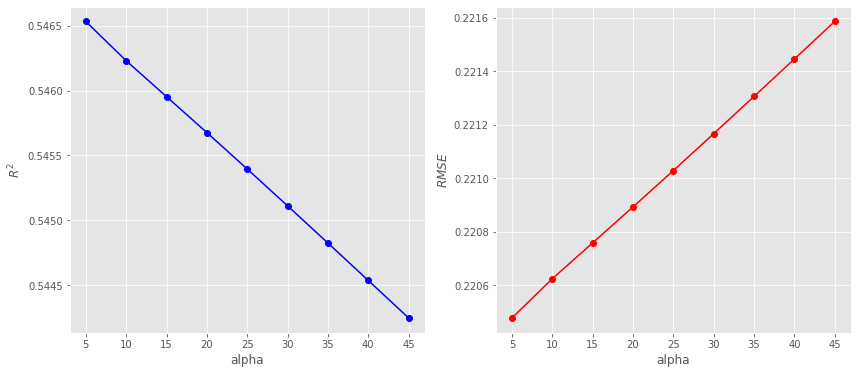

In [81]:
%matplotlib inline
import matplotlib.style as style
style.use("ggplot")
fig,axes=plt.subplots(1,2,figsize=(14,6))
axes[0].plot(alpha, r2_list,'o-',color='blue')
axes[1].plot(alpha,rmse_list,'o-',color='red')
axes[0].set_xlabel("alpha")
axes[0].set_ylabel("$R^2$")
axes[1].set_xlabel("alpha")
axes[1].set_ylabel("$RMSE$")
plt.subplots_adjust(wspace=0.2,
                   hspace=0.2)
print(f'max R2 is{max(r2_list)},the alpah is {alpha[r2_list.index(max(r2_list))]}')
print(f'min RMSE is{min(rmse_list)},the alpah is {alpha[rmse_list.index(min(rmse_list))]}')

we can see that optimal alpha level should be less than 5. We will run another searching for the best alpha value

max R2 is0.5468210715155947,the alpah is 1.1111111111111112
min RMSE is0.2203376065538193,the alpah is 1.1111111111111112


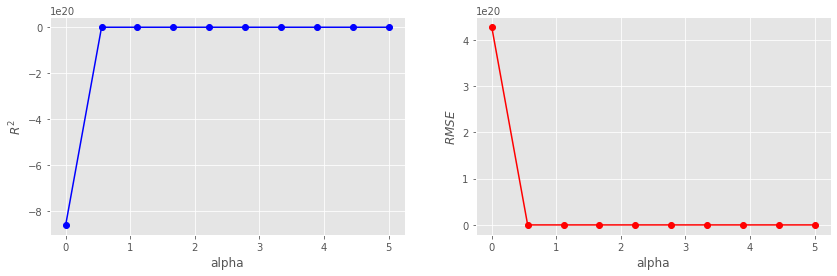

In [82]:
#alpha from 0 to 5
alpha2 = np.linspace(0, 5, 10)
r2_list2=[]
rmse_list2=[]
for i in alpha2:
    ridge_r2_score=r2_score(Ridge(alpha=i))
    r2_list2.append(ridge_r2_score.mean())
    ridge_rmse_score=-rmse_score(Ridge(alpha=i))
    rmse_list2.append(ridge_rmse_score.mean())
    
fig,axes=plt.subplots(1,2,figsize=(14,4))
axes[0].plot(alpha2, r2_list2,'o-',color='blue')
axes[1].plot(alpha2,rmse_list2,'o-',color='red')

axes[0].set_xlabel("alpha")
axes[0].set_ylabel("$R^2$")
axes[1].set_xlabel("alpha")
axes[1].set_ylabel("$RMSE$")

plt.subplots_adjust(wspace=0.2,
                   hspace=0.2)
print(f'max R2 is{max(r2_list2)},the alpah is {alpha2[r2_list2.index(max(r2_list2))]}')
print(f'min RMSE is{min(rmse_list2)},the alpah is {alpha2[rmse_list2.index(min(rmse_list2))]}')

The optimal alpha value is 2.7. In sklearn, the major parameter for Ridge model is alpha, so we can use this alpha level to run on test set.

In [83]:
from sklearn.metrics import mean_squared_error, balanced_accuracy_score

best_alpha = alpha2[np.argmax(r2_list2)]
ridge_best = r2_score(Ridge(alpha=best_alpha))
ridge_model = Ridge(alpha=best_alpha)
ridge_model = ridge_model.fit(Xtrain,ytrain)
predict_ytrain = ridge_model.predict(Xtrain)
predict_ytest = ridge_model.predict(Xtest)
ridge_results=pd.DataFrame({'algorithm':['Ridge Regression'],
                           'CV_ridge_r2:':ridge_best.mean(),
                            'train error:':mean_squared_error(predict_ytrain,ytrain),
                            'test error:':mean_squared_error(predict_ytest,ytest)
                           }
)
ridge_results

,algorithm,CV_ridge_r2:,train error:,test error:
0,Ridge Regression,0.546821,0.217443,0.205672


## 6.4 Random Forest Regressor

In [84]:
#base model
base_rfr_cv = r2_score(RandomForestRegressor(random_state=42))
base_rfr_model=RandomForestRegressor(random_state=42)
base_rfr_model = base_rfr_model.fit(Xtrain,ytrain)
rfr_predict_ytrain = base_rfr_model.predict(Xtrain)
rfr_predict_ytest = base_rfr_model.predict(Xtest)
base_rfr_result=pd.DataFrame({'model':['RandomForestRegressor'],
                'CV_rfr_r2:':base_rfr_cv.mean(),
                'train error:':mean_squared_error(rfr_predict_ytrain,ytrain),
                'test error:':mean_squared_error(rfr_predict_ytest,ytest)})
base_rfr_result

,model,CV_rfr_r2:,train error:,test error:
0,RandomForestRegressor,0.59214,0.027696,0.183791


In [85]:
base_rfr_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

There are many parameters if we search on by one. We can use RandomSearchCV to explore first.

In [86]:
from sklearn.model_selection import  RandomizedSearchCV
n_estimators=[x for x in range(20,2000,20)]
max_depth=[x for x in range(1,10,1)]
max_features=['auto','sqrt']
min_samples_split=[2,4,7]
min_samples_leaf=[1,2,4]
bootstrap=[True,False]
random_grid={'n_estimators':n_estimators,
             'max_features':max_features,
             'max_depth':max_depth,
             'min_samples_split':min_samples_split,
             'min_samples_leaf':min_samples_leaf,
             'bootstrap':bootstrap
}
rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), param_distributions = random_grid, n_iter=10, cv = 3, verbose=2, random_state=42)
rf_random.fit(Xtrain, ytrain)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=1860, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=5, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1860, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=5, bootstrap=False, total= 4.4min
[CV] n_estimators=1860, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=5, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.4min remaining:    0.0s


[CV]  n_estimators=1860, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=5, bootstrap=False, total= 4.5min
[CV] n_estimators=1860, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=5, bootstrap=False 
[CV]  n_estimators=1860, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=5, bootstrap=False, total= 4.9min
[CV] n_estimators=1100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=9, bootstrap=True 
[CV]  n_estimators=1100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=9, bootstrap=True, total=  29.4s
[CV] n_estimators=1100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=9, bootstrap=True 
[CV]  n_estimators=1100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=9, bootstrap=True, total=  24.2s
[CV] n_estimators=1100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=9, bootstrap=True 
[CV]  n_estimators=1100, min_samp

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 56.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [87]:
#check the optimal model parameters from RandomSearch
best_rfr=rf_random.best_estimator_
best_rfr

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=7, min_weight_fraction_leaf=0.0,
                      n_estimators=1960, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

n_estimators is 1960 looks a bit large. Let's run on test set to see performance

In [88]:
rfr_best_score=r2_score(best_rfr)
rfr_best_model=best_rfr.fit(Xtrain,ytrain)
predict_ytrain_rfr=rfr_best_model.predict(Xtrain)
precict_ytest_rfr = rfr_best_model.predict(Xtest)
rfr_result=pd.DataFrame({'algorithm:':['RandomForestRegressor'],
                        'CV_rfr_r2:':rfr_best_score.mean(),
                        'train error:':mean_squared_error(predict_ytrain_rfr,ytrain),
                        'test error:':mean_squared_error(precict_ytest_rfr,ytest)}
                       )
rfr_result

,algorithm:,CV_rfr_r2:,train error:,test error:
0,RandomForestRegressor,0.565401,0.19974,0.198567


Model performance has improved. To further improve the performance, considering there're many dummy variables that makes high dimension, we can use feature selection to exclude some unimportant features.



### 6.4.1 Feature Selection

For purpose of interpratability, we will not use PCA.

In [136]:
#standarization
columns=X.columns.tolist()
scaler=RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns=columns)
X.head()


#feature selection
from sklearn.feature_selection import VarianceThreshold
selector=VarianceThreshold(.9*(1-.9))
X_var = selector.fit_transform(X)

#columns from feature selection
X_var_columns = X.columns[selector.get_support(indices=True)]
X_var = pd.DataFrame(X_var,columns=X_var_columns)
X_var.head()

,latitude,longitude,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,room_type_Entire home/apt,room_type_Private room
0,-1.035130,-0.356662,-0.630930,0.173913,-0.064298,-0.103896,5.0,1.409692,1.0,0.0,0.0,-1.0,1.0
1,0.418407,-0.600278,-0.630930,1.739130,0.116751,0.006494,1.0,1.365639,0.0,1.0,0.0,0.0,0.0
2,1.177155,0.294476,0.000000,-0.217391,-2.401015,-0.240260,0.0,1.409692,0.0,1.0,0.0,-1.0,1.0
3,-0.519482,-0.087189,-0.630930,11.521739,0.154822,2.772727,0.0,0.656388,1.0,0.0,0.0,0.0,0.0
4,1.033212,0.249813,0.920799,0.173913,-0.038071,-0.175325,0.0,-0.198238,0.0,1.0,0.0,0.0,0.0


In [90]:
X_var.columns

Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'room_type_Entire home/apt', 'room_type_Private room'],
      dtype='object')

In [137]:
#set train and test splits again
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=42)

### 6.4.2 Random Forest - tune parameters


In random forest some important parameters are:  n_estimators, max_depth, max_features, min_sample_leaf， and min_sample_split.

n_estimators - number of trees，other parameters are about characteristics for each tree. First leave out n_estimators and tune other parameters will improve efficiency. 

So first to tune max_depth, max_features, min_sample_leaf， min_sample_split with cross-validation.

In [92]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [93]:
#to avoid warnings, we set n_estimators to 10.
n_estimators=[10]
max_depth=[i for i in range(5,10,2)]
max_features=[i for i in range(5,14,1)]
min_samples_leaf=[i for i in range(2,10,1)]
min_samples_split=[i for i in range(2,5,1)]
parameters = {
    'n_estimators':n_estimators,
    'max_depth':max_depth,
    'max_features':max_features,
    'min_samples_leaf':min_samples_leaf,
    'min_samples_split':min_samples_split
}
rfr = RandomForestRegressor(random_state=42)
GS=GridSearchCV(rfr,parameters,cv=3)
GS.fit(Xtrain,ytrain)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [94]:
GS.best_params_

{'max_depth': 9,
 'max_features': 12,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 10}

We can tell from cross-validation result that there's no need to tune min_samples_split，thus we can move on to see learning rate of other parameters. 

In [95]:
#max_depth
train_score_list=[]
train_error_list=[]
test_score_list=[]
test_error_list=[]
for i in range(9,29,1):
    model = RandomForestRegressor(max_depth=i,random_state=42).fit(Xtrain,ytrain)
    train_score = model.score(Xtrain,ytrain)
    train_score_list.append(train_score)
    test_score = model.score(Xtest,ytest)
    test_score_list.append(test_score)
    predict_ytrain=model.predict(Xtrain)
    predict_ytest =model.predict(Xtest)
    train_error=mean_squared_error(predict_ytrain,ytrain)
    test_error = mean_squared_error(predict_ytest,ytest)
    train_error_list.append(train_error)
    test_error_list.append(test_error)

The min testSet error is 0.18569739045829367 when max_depth = 16


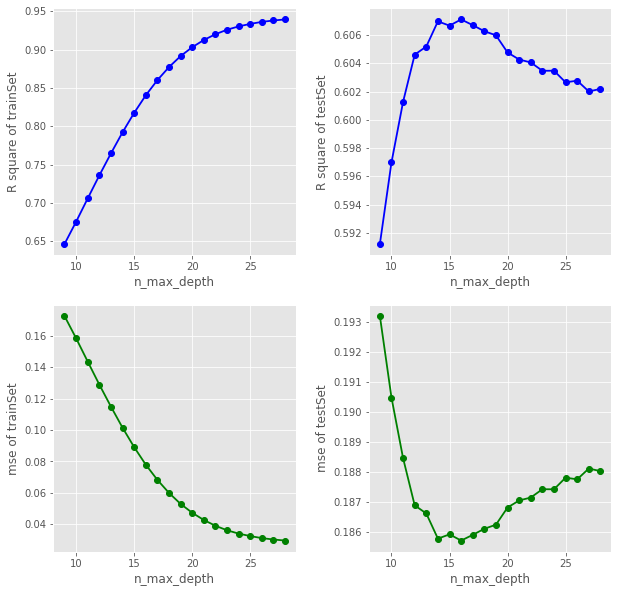

In [116]:
import matplotlib.style as style
style.use('ggplot')
x=[i for i in range(9,29,1)]
fig,ax=plt.subplots(2,2,figsize=(10,10))
ax[0][0].plot(x,train_score_list,'o-',linewidth=1.8 ,color='blue')
ax[0][0].set_xlabel(xlabel='n_max_depth')
ax[0][0].set_ylabel(ylabel='R square of trainSet')

ax[0][1].plot(x,test_score_list,'o-',linewidth=1.8,color='blue')
ax[0][1].set_xlabel(xlabel='n_max_depth')
ax[0][1].set_ylabel(ylabel='R square of testSet')

ax[1][0].plot(x,train_error_list,'o-',linewidth=1.8,color='green')
ax[1][0].set_xlabel(xlabel='n_max_depth')
ax[1][0].set_ylabel(ylabel='mse of trainSet')

ax[1][1].plot(x,test_error_list,'o-',linewidth=1.8,color='green')
ax[1][1].set_xlabel(xlabel='n_max_depth')
ax[1][1].set_ylabel(ylabel='mse of testSet')
plt.subplots_adjust(
#                     left=0.1
#                     , bottom=0.1
#                     ,right=0.2
#                     ,top=None
#                     ,
    wspace=0.3
                    ,hspace=0.2
                   )
print(f"The min testSet error is {min(test_error_list)} when max_depth = {x[np.argmin(test_error_list)]}")

We can tell that when max_depth is equal to 16 the predictive performance on test set is the best. When max_depth is larger than 16，with increase of value，the performance decrease. In this bias-variance tradeoff, we will choose max_depth=16

In [120]:
#max_features
train_score_list2=[]
train_error_list2=[]
test_score_list2=[]
test_error_list2=[]
for i in range(20,50,1):
    model = RandomForestRegressor(max_depth=16,max_features=i,random_state=42).fit(Xtrain,ytrain)
    train_score = model.score(Xtrain,ytrain)
    train_score_list2.append(train_score)
    test_score = model.score(Xtest,ytest)
    test_score_list2.append(test_score)
    predict_ytrain=model.predict(Xtrain)
    predict_ytest =model.predict(Xtest)
    train_error=mean_squared_error(predict_ytrain,ytrain)
    test_error = mean_squared_error(predict_ytest,ytest)
    train_error_list2.append(train_error)
    test_error_list2.append(test_error)

The min testSet error is 0.18364921558813696 when max_feature = 49


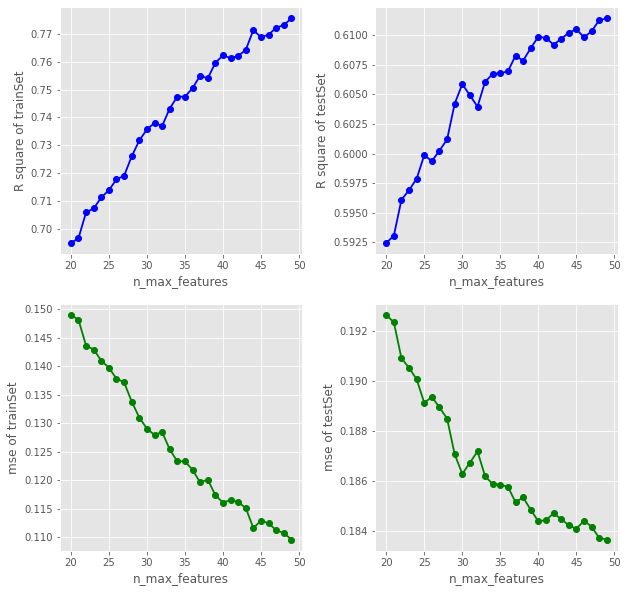

In [121]:
import matplotlib.style as style
style.use('ggplot')
x=[i for i in range(20,50,1)]
fig,ax=plt.subplots(2,2,figsize=(10,10))
ax[0][0].plot(x,train_score_list2,'o-',linewidth=1.8 ,color='blue')
ax[0][0].set_xlabel(xlabel='n_max_features')
ax[0][0].set_ylabel(ylabel='R square of trainSet')

ax[0][1].plot(x,test_score_list2,'o-',linewidth=1.8,color='blue')
ax[0][1].set_xlabel(xlabel='n_max_features')
ax[0][1].set_ylabel(ylabel='R square of testSet')

ax[1][0].plot(x,train_error_list2,'o-',linewidth=1.8,color='green')
ax[1][0].set_xlabel(xlabel='n_max_features')
ax[1][0].set_ylabel(ylabel='mse of trainSet')

ax[1][1].plot(x,test_error_list2,'o-',linewidth=1.8,color='green')
ax[1][1].set_xlabel(xlabel='n_max_features')
ax[1][1].set_ylabel(ylabel='mse of testSet')
plt.subplots_adjust(
#                     left=0.1
#                     , bottom=0.1
#                     ,right=0.2
#                     ,top=None
#                     ,
    wspace=0.3
                    ,hspace=0.2
                   )
print(f"The min testSet error is {min(test_error_list2)} when max_feature = {x[np.argmin(test_error_list2)]}")

Here we use max_features=49.

The min testSet error is 0.18660942971289443 when min_samples_leaf = 6


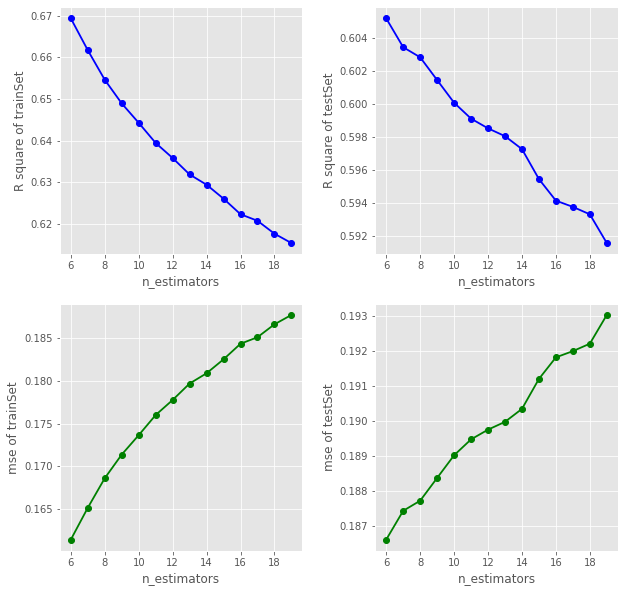

In [122]:
#min_samples_leaf
train_score_list3=[]
train_error_list3=[]
test_score_list3=[]
test_error_list3=[]
for i in range(6,20,1):
    model = RandomForestRegressor(max_depth=16,min_samples_leaf=i,max_features=49,random_state=42).fit(Xtrain,ytrain)
    train_score = model.score(Xtrain,ytrain)
    train_score_list3.append(train_score)
    test_score = model.score(Xtest,ytest)
    test_score_list3.append(test_score)
    predict_ytrain=model.predict(Xtrain)
    predict_ytest =model.predict(Xtest)
    train_error=mean_squared_error(predict_ytrain,ytrain)
    test_error = mean_squared_error(predict_ytest,ytest)
    train_error_list3.append(train_error)
    test_error_list3.append(test_error)

import matplotlib.style as style
style.use('ggplot')
x=[i for i in range(6,20,1)]
fig,ax=plt.subplots(2,2,figsize=(10,10))
ax[0][0].plot(x,train_score_list3,'o-',linewidth=1.8 ,color='blue')
ax[0][0].set_xlabel(xlabel='n_estimators')
ax[0][0].set_ylabel(ylabel='R square of trainSet')

ax[0][1].plot(x,test_score_list3,'o-',linewidth=1.8,color='blue')
ax[0][1].set_xlabel(xlabel='n_estimators')
ax[0][1].set_ylabel(ylabel='R square of testSet')

ax[1][0].plot(x,train_error_list3,'o-',linewidth=1.8,color='green')
ax[1][0].set_xlabel(xlabel='n_estimators')
ax[1][0].set_ylabel(ylabel='mse of trainSet')

ax[1][1].plot(x,test_error_list3,'o-',linewidth=1.8,color='green')
ax[1][1].set_xlabel(xlabel='n_estimators')
ax[1][1].set_ylabel(ylabel='mse of testSet')
plt.subplots_adjust(
#                     left=0.1
#                     , bottom=0.1
#                     ,right=0.2
#                     ,top=None
#                     ,
    wspace=0.3
                    ,hspace=0.2
                   )
print(f"The min testSet error is {min(test_error_list3)} when min_samples_leaf = {x[np.argmin(test_error_list3)]}")

Now we identified the best values of parameters from the corresponding learning curves: max_depth=16,max_features=49,min_samples_leaf=6

In [123]:
model = RandomForestRegressor(max_depth=16,max_features=49,min_samples_leaf=6,random_state=42).fit(Xtrain,ytrain)
print(f'train Score is {model.score(Xtrain,ytrain)}')
print(f'test Score is {model.score(Xtest,ytest)}')
print(f'train mse is {mean_squared_error(model.predict(Xtrain),ytrain)}')
print(f'train mse is {mean_squared_error(model.predict(Xtest),ytest)}')

train Score is 0.6693726067757046
test Score is 0.6051656189526207
train mse is 0.161391996379639
train mse is 0.18660942971289443


n_estimators 

The min testSet error is 0.18691826335218986 when n_estimators = 55


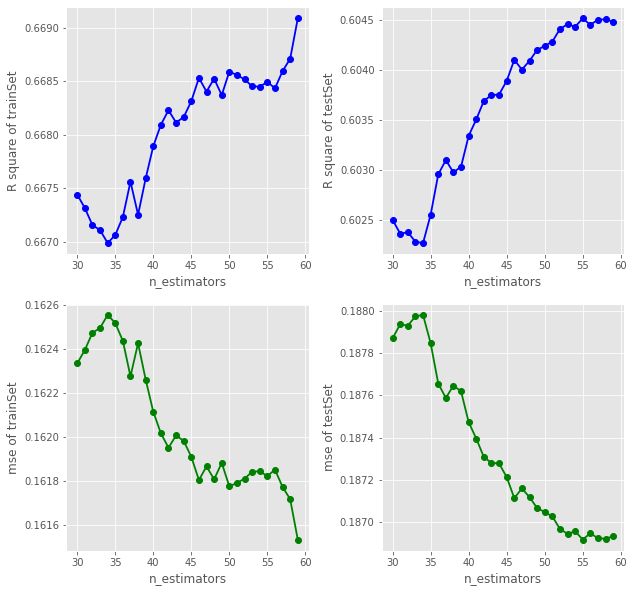

In [125]:
n_estimators=[i for i in range(30,60,1)]
train_score_list5=[]
test_score_list5=[]
train_error_list5=[]
test_error_list5=[]

for i in n_estimators:
    rfr = RandomForestRegressor(random_state=42,n_estimators=i,max_depth=16,max_features=49,min_samples_leaf=6)
    rfr = rfr.fit(Xtrain,ytrain)
    train_score_list5.append(rfr.score(Xtrain,ytrain))
    test_score_list5.append(rfr.score(Xtest,ytest))
    predict_ytrain = rfr.predict(Xtrain)
    predict_ytest = rfr.predict(Xtest)
    mse_train=mean_squared_error(predict_ytrain,ytrain)
    mse_test=mean_squared_error(predict_ytest,ytest)
    train_error_list5.append(mse_train)
    test_error_list5.append(mse_test)

#可视化
import matplotlib.style as style
style.use('ggplot')
x=[i for i in range(30,60,1)]
fig,ax=plt.subplots(2,2,figsize=(10,10))
ax[0][0].plot(x,train_score_list5,'o-',linewidth=1.8 ,color='blue')
ax[0][0].set_xlabel(xlabel='n_estimators')
ax[0][0].set_ylabel(ylabel='R square of trainSet')

ax[0][1].plot(x,test_score_list5,'o-',linewidth=1.8,color='blue')
ax[0][1].set_xlabel(xlabel='n_estimators')
ax[0][1].set_ylabel(ylabel='R square of testSet')

ax[1][0].plot(x,train_error_list5,'o-',linewidth=1.8,color='green')
ax[1][0].set_xlabel(xlabel='n_estimators')
ax[1][0].set_ylabel(ylabel='mse of trainSet')

ax[1][1].plot(x,test_error_list5,'o-',linewidth=1.8,color='green')
ax[1][1].set_xlabel(xlabel='n_estimators')
ax[1][1].set_ylabel(ylabel='mse of testSet')
plt.subplots_adjust(
#                     left=0.1
#                     , bottom=0.1
#                     ,right=0.2
#                     ,top=None
#                     ,
    wspace=0.3
                    ,hspace=0.2
                   )
print(f"The min testSet error is {min(test_error_list5)} when n_estimators = {x[np.argmin(test_error_list5)]}")

When n_estimators>55，with the increase of value，test residual flucturate in some range. We can think there's no more space to improve model performance with n_estimators. Threfore we select the value where test set has the smallest RMSE: n_estimators=55

### 6.4.3 Final RF Model

In [126]:
model_best = RandomForestRegressor(max_depth=16,max_features=49,min_samples_leaf=6,random_state=42,n_estimators=55).fit(Xtrain,ytrain)
print(f'train Score is {model_best.score(Xtrain,ytrain)}')
print(f'test Score is {model_best.score(Xtest,ytest)}')
print(f'train mse is {mean_squared_error(model_best.predict(Xtrain),ytrain)}')
print(f'train mse is {mean_squared_error(model_best.predict(Xtest),ytest)}')

train Score is 0.6684924242770915
test Score is 0.6045121785610743
train mse is 0.1618216474416526
train mse is 0.18691826335218986


### 6.4.4 Model Evaluation

First let's check the residuals distribution:

Prediction with residual less than 1:97.1%


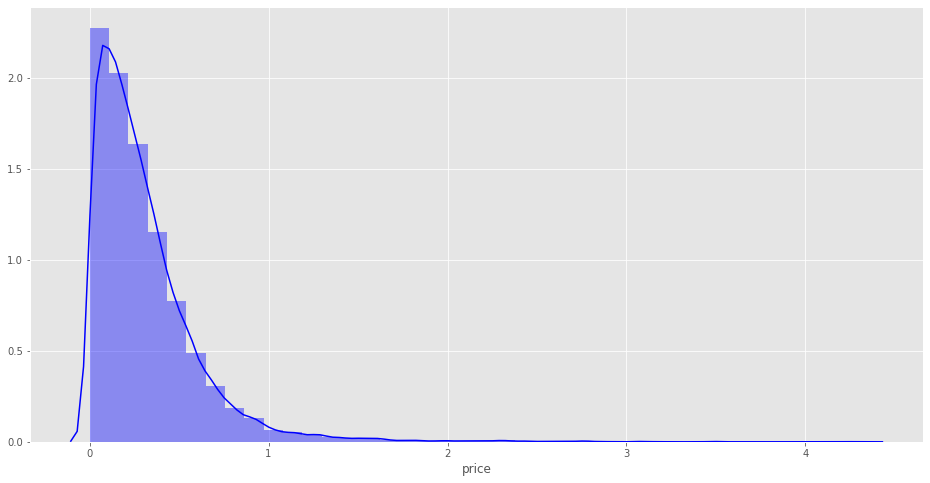

In [129]:
predict_ytest = model_best.predict(Xtest)
predict_error = np.abs(predict_ytest-ytest)
percent=("%.3f"%(predict_error[predict_error<1].shape[0]/predict_error.shape[0]))
fig,ax=plt.subplots(figsize=(16,8))
import seaborn as sns
sns.distplot(predict_error,ax=ax,color='blue',bins=40)
print(f"Prediction with residual less than 1:{float(percent)*100}%")

From the residual distribution plot we can see that 97% of the absolute errors are within 1.

Text(3.5, 3.4, '$predict_y + 1 = Test_y$')

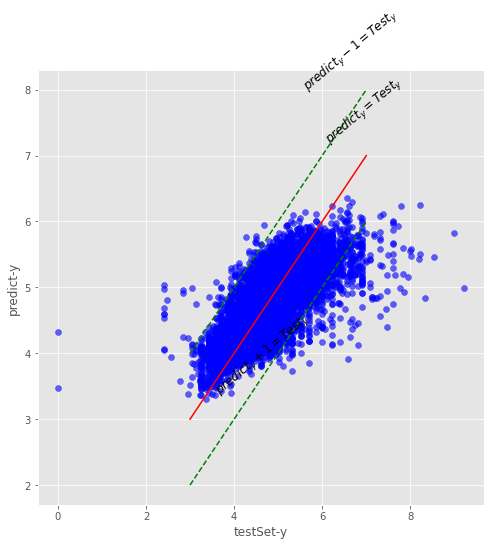

In [130]:
fig,ax=plt.subplots(figsize=(8,8))
plt.scatter(x=ytest,y=predict_ytest,alpha=.6,color='blue')
plt.plot(np.arange(3,8),np.arange(3,8),c='red')
plt.plot(np.arange(3,8),np.arange(2,7),c='green',linestyle='--')
plt.plot(np.arange(3,8),np.arange(4,9),c='green',linestyle='--')
ax.set_xlabel(xlabel="testSet-y")
ax.set_ylabel(ylabel="predict-y")
ax.text(x=6,y=7.2,s="$predict_y = Test_y$",rotation=40,fontsize=12)
ax.text(x=5.5,y=8,s="$predict_y -1 = Test_y$",rotation=40,fontsize=12)
ax.text(x=3.5,y=3.4,s="$predict_y + 1 = Test_y$",rotation=40,fontsize=12)

### 6.4.5 RMSE and MAE

We will use the real price, instead of the log transformed values, to see model performance Mean Abosulute Errors and Root Mean Square Error.


In [138]:
predict_ytest = np.expm1(model_best.predict(Xtest)) #take the exponential 

ytest=np.expm1(ytest)
predict_error = np.abs(predict_ytest-ytest)
percent=("%.3f"%(predict_error[predict_error<150].shape[0]/predict_error.shape[0]))

#put predicted values and real values in a tem dataframe
temp1 = pd.Series(ytest.values.tolist())
temp2 = pd.Series(predict_ytest.tolist())
test_result_df=pd.concat([temp1,temp2],axis=1)
test_result_df.columns=['y','predict']


test_result_df.describe(percentiles=[ .75,.8,.85, .9, .95])

,y,predict
count,14669.000000,14669.000000
mean,149.450201,128.382643
std,200.972787,66.698541
min,0.000000,26.206676
50%,106.000000,117.059391
75%,175.000000,172.804227
80%,199.000000,184.569382
85%,225.000000,197.710889
90%,260.000000,219.211541
95%,350.000000,253.961999


We can see that predicted values less than 253 accounts for 95%, and there are 95% of the actual price are within 350.
Since this dataset does not provide square feet of each listings, we can only estimate the most common cases. 

Therefore, we can evaluate again with test listings that with the price less than 255 and get:

- MAE :28.537426651314323
- RMSE39.74879758084003


Based on this result we can provide a reasonable range of prices for new hosts according to their locations.

## 6.5 Discussions about important factors for price

In [139]:
importance = model_best.feature_importances_
columns = Xtrain.columns
s = pd.Series(data=importance,index=columns)
s.sort_values(ascending=False)

room_type_Entire home/apt        0.257984
room_type_Private room           0.218705
longitude                        0.121738
latitude                         0.084276
neighbourhood_group_Manhattan    0.053792
                                   ...   
neighbourhood_Morris Heights     0.000000
neighbourhood_Morris Park        0.000000
neighbourhood_Morrisania         0.000000
neighbourhood_Mount Eden         0.000000
neighbourhood_Huguenot           0.000000
Length: 237, dtype: float64

Results show that the most influencial factor is room type, and then is longitude and latitude, following by availability and whether it's in Manhattan.

# 7. Conclusion

- Manhaatan and Brooklyn have the majority of listings
- Room types are house/apt and bedroom
- Price less than 500，longitude close to -73.9 ~ -74.0，latitude close to 40.7 has the most popularity 
- The most important factors for price is the room type, then location 